The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. This notebook illustrates the use of Spark in SWAN to analyze the monitoring data available on HDFS and plots a heatmap of loadAvg across machines in a particular service.

### Connect to the cluster

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready

### Import necessary spark and python stuff

In [2]:
from pyspark.sql.functions import from_unixtime, when, col
from pyspark.sql.types import *
from pyspark.sql.functions import from_json

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### select the data
*path_on_hdfs_to_your_data*

In [4]:
df = spark.read.json("/user/rucio01/traces/traces.2018-03*")

### check the structure

In [5]:
df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- account: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- catStart: double (nullable = true)
 |-- clientState: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- datasetScope: string (nullable = true)
 |-- duid: string (nullable = true)
 |-- eventType: string (nullable = true)
 |-- eventVersion: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- filesize: string (nullable = true)
 |-- guid: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- localSite: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pq: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- relativeStart: double (nullable = true)
 |-- remoteSite: string (nullable = true)
 |-- scope: string (nullable = true)
 |-- stateReason: string (nullable = true)
 |-- suspicious: string (nullable = true)
 |-- taskid: string (nullable = tru

### Filter for loadAvg
_https://metricmgr.cern.ch/metric/20002/_

In [6]:
#body_schema = StructType([StructField("LoadAvg",DoubleType())])
#df_loadAvg = df.where(col("metric_id") == "20002").withColumn('body', from_json('body', body_schema))

### Create temporary table view

In [7]:
# body_schema = spark.read.json(df_loadAvg.rdd.map(lambda row: row.body)).schema
df.createOrReplaceTempView("traces")

### Do the heavylifting in spark and collect aggregated view to panda DF

In [42]:
df_pandas = spark.sql("SELECT eventVersion, \
                                      eventType, \
                                      count(*), \
                                      remoteSite \
                               FROM traces \
                               WHERE clientState = 'DONE'\
                               GROUP BY eventVersion, eventType, remoteSite")\
                    .toPandas()

### Visualize with seaborn

In [43]:
# heatmap of service availability
df_pandas
#plt.figure(figsize=(10, 6))
#ax = sns.heatmap(df_loadAvg_pandas.pivot(index='submitter_host', columns='hr', values='avg'), cmap="Blues")
#ax.set_title("Heatmap of loadAvg")

eventVersion      eventType  count(1)  \
0          pilot3       get_sm_a    274493   
1         1.14.10         upload     34465   
2          pilot3       get_sm_a     79695   
3          pilot3         get_sm       153   
4          pilot3  put_sm_logs_a         8   
5          pilot3    put_sm_logs         3   
6         1.14.11       download        25   
7          pilot3       get_sm_a        12   
8          pilot3  put_sm_logs_a     11714   
9         1.14.11       download   3294783   
10         pilot3  put_sm_logs_a     72172   
11        1.14.10         upload        54   
12        1.14.11       download    832082   
13         pilot3  put_sm_logs_a         8   
14        1.14.11         upload       155   
15        1.14.10         upload       111   
16         1.15.2       download         2   
17         pilot3       get_sm_a    184707   
18         pilot3  put_sm_logs_a      6007   
19         pilot3       get_sm_a      2496   
20         pilot3       get_sm_a     56353   
21         pilot3       get_sm_a     67866   
22         pilot3         put_sm     14164   
23        1.14.11         upload       150   
24         1.13.2       download       249   
25        1.14.11         upload       146   
26         1.13.2       download        21   
27        1.14.11       download        50   
28         pilot3         put_sm     15604   
29         pilot3         get_es    413660   
...           ...            ...       ...   
1842      1.14.10         upload     16688   
1843       pilot3       get_sm_a     11688   
1844      1.14.11       download       364   
1845       pilot3       get_sm_a       800   
1846      1.14.11       download     10543   
1847      1.14.11       download         2   
1848      1.14.11         upload    657161   
1849       pilot3         put_sm     63968   
1850      1.14.11       download      5172   
1851       pilot3    put_sm_logs     61451   
1852       pilot3       get_sm_a     76952   
1853       pilot3    put_sm_logs     25056   
1854       pilot3    put_sm_logs     18516   
1855       pilot3       put_sm_a     21114   
1856      1.14.10         upload      3558   
1857      1.14.10       download       426   
1858      1.14.11         upload       187   
1859       1.13.2       download        10   
1860      1.14.11         upload        98   
1861       pilot3    put_sm_logs         1   
1862       pilot3       get_sm_a    803838   
1863       pilot3  put_sm_logs_a     75394   
1864      1.14.10       download     10698   
1865      1.14.10         upload      1853   
1866      1.14.11         upload      5175   
1867       1.13.2       download        24   
1868      1.14.10       download      1201   
1869      1.14.10       download        69   
1870       pilot3       get_sm_a        17   
1871       pilot3         get_sm         6   

                                remoteSite  
0                    GRIF-IRFU_SCRATCHDISK  
1      UKI-NORTHGRID-LANCS-HEP_SCRATCHDISK  
2                  RO-07-NIPNE_SCRATCHDISK  
3                GRIF-LPNHE_LOCALGROUPDISK  
4                           MPPMU_DATADISK  
5                IEPSAS-KOSICE_SCRATCHDISK  
6                       CERN-PROD_DET-LARG  
7                    ANALY_TAIWAN_HPC_QDR5  
8                NCG-INGRID-PT_SCRATCHDISK  
9                       CERN-PROD_DATADISK  
10       UKI-NORTHGRID-LIV-HEP_SCRATCHDISK  
11                   TECHNION-HEP_DATADISK  
12                                 MWT2_ES  
13                        LRZ-LMU_DATADISK  
14                        GOEGRID_DATADISK  
15                AUSTRALIA-ATLAS_DATADISK  
16                   CERN-PROD_SCRATCHDISK  
17               WUPPERTALPROD_SCRATCHDISK  
18               TR-10-ULAKBIM_SCRATCHDISK  
19                   TECHNION-HEP_DATADISK  
20                      IFIC-LCG2_DATADISK  
21                          AGLT2_DATADISK  
22                       RAL-LCG2_DATADISK  
23                        DESY-ZN_DATADISK  
24                     MWT2

In [44]:
import pyspark
#df = spark.read.format("com.databricks.spark.avro").load("/user/rucio01/dumps/2018-04-24/rses")

In [45]:
dir(pyspark)

['Accumulator',
 'AccumulatorParam',
 'BasicProfiler',
 'Broadcast',
 'HiveContext',
 'MarshalSerializer',
 'PickleSerializer',
 'Profiler',
 'RDD',
 'Row',
 'SQLContext',
 'SparkConf',
 'SparkContext',
 'SparkFiles',
 'SparkJobInfo',
 'SparkStageInfo',
 'StatusTracker',
 'StorageLevel',
 'TaskContext',
 '__all__',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__path__',
 '__version__',
 'accumulators',
 'broadcast',
 'cloudpickle',
 'conf',
 'context',
 'copy_func',
 'files',
 'find_spark_home',
 'heapq3',
 'java_gateway',
 'join',
 'keyword_only',
 'profiler',
 'rdd',
 'rddsampler',
 'resultiterable',
 'serializers',
 'shuffle',
 'since',
 'sql',
 'statcounter',
 'status',
 'storagelevel',
 'taskcontext',
 'traceback_utils',
 'types',
 'util',
 'version',
 'wraps']

In [46]:
df_pandas2 = spark.sql("SELECT dataset, \
                               from_unixtime(traceTimeentryUnix, 'YYYY-MM-dd') AS dt, \
                               count(*) as amount \
                               FROM traces \
                               WHERE eventType = 'download' AND from_unixtime(traceTimeentryUnix, 'YYYY-MM-dd') >= date_add(current_date(), -30)\
                               GROUP BY 1, 2 \
                               HAVING count(1) < 10000 \
                               ORDER BY 3 DESC")\
                    .toPandas()

In [47]:
df_pandas2

dataset          dt  amount
0      user.aleopold.hgtd_tt_mu200_newRPT_leadingEvt....  2018-03-30    9656
1      user.aleopold.hgtd_tt_mu200_newRPT.2018_03_27_...  2018-03-28    9644
2      data15_13TeV.periodJ.physics_Main.PhysCont.DAO...  2018-03-29    9004
3      user.malutz.data16_13TeV.00304008.physics_Main...  2018-03-30    8706
4      user.ljiang.data.data16_13TeV.00299184.physics...  2018-03-29    8058
5      user.bbrunt.ChargeFlavourAsymm.XAODCode.data_1...  2018-03-28    7973
6      user.ljiang.data.data16_13TeV.00299584.physics...  2018-03-31    7530
7      mc16_13TeV.364352.Sherpa_224_NNPDF30NNLO_Dipho...  2018-03-28    6653
8      mc16_13TeV.361224.Epos_minbias_inelastic.simul...  2018-03-28    6373
9      user.vdao.mc15_13TeV.345786.PhPy8EG_NNPDF3_AZN...  2018-03-30    6351
10     data15_13TeV.periodJ.physics_Main.PhysCont.DAO...  2018-03-28    6115
11     user.vdao.mc15_13TeV.345823.PhPy8EG_NNPDF3_AZN...  2018-03-30    5537
12     user.bbrunt.ChargeFlavourAsymm.XAODCode.data_1...  2018-03-28    5080
13     user.vdao.mc15_13TeV.345792.PhPy8EG_NNPDF3_AZN...  2018-03-30    4972
14     user.vdao.mc15_13TeV.345804.PhPy8EG_NNPDF3_AZN...  2018-03-30    4800
15     data15_13TeV.00267385.physics_MinBias.recon.AO...  2018-03-29    4557
16     user.vdao.mc15_13TeV.345798.PhPy8EG_NNPDF3_AZN...  2018-03-30    4000
17     group.phys-higgs.mc15_13TeV.362449.Sherpa_Wenu...  2018-03-28    3886
18     group.phys-higgs.mc15_13TeV.362449.Sherpa_Wenu...  2018-03-28    3861
19     user.vdao.mc15_13TeV.345829.PhPy8EG_NNPDF3_AZN...  2018-03-30    3600
20     user.vdao.mc15_13TeV.345817.PhPy8EG_NNPDF3_AZN...  2018-03-30    3488
21     user.vdao.mc15_13TeV.345571.PowhegHerwig7EvtGe...  2018-03-30    3456
22                     user.iconnell.Top.PRW.MC16c.FS.v1  2018-03-31    3309
23     user.vdao.mc15_13TeV.345799.PhPy8EG_NNPDF3_AZN...  2018-03-30    3303
24     group.phys-higgs.mc16_13TeV.361026.CAOD_HIGG5D...  2018-03-29    3294
25     group.phys-higgs.mc15_13TeV.362449.Sherpa_Wenu...  2018-03-28    3264
26     user.ljiang.data.data16_13TeV.00299184.physics...  2018-03-28    3085
27     user.malutz.mc15_13TeV.361506.MadGraphPythia8E...  2018-03-30    2957
28     user.artprod.atlas.21.3.Athena.x86_64-slc6-gcc...  2018-03-28    2885
29     user.artprod.atlas.master.Athena.x86_64-slc6-g...  2018-03-29    2873
...                                                  ...         ...     ...
38115  group.phys-hi.mc15_5TeV.420022.PowhegPythia8Ev...  2018-03-29       1
38116  user.lveloce.group.phys-higgs.mc16_13TeV.34423...  2018-03-28       1
38117  user.ivivarel.406169.MadGraphPythia8EvtGen_A14...  2018-03-31       1
38118                         user.vbegy.stagein8698.log  2018-03-28       1
38119  user.sutt.atlas.21.0.Athena.x86_64-slc6-gcc62-...  2018-03-31       1
38120  user.sutt.atlas.21.1.AthenaP1.x86_64-slc6-gcc6...  2018-03-31       1
38121                         user.vbegy.stagein1645.log  2018-03-28       1
38122  group.perf-jets.D17.00331239.Mar27.Zee.EM.p337...  2018-03-29       1
38123                         user.vbegy.stagein6237.log  2018-03-29       1
38124  user.fcirotto.bkg.mc16a.22Mar.mc16_13TeV.30809...  2018-03-28       1
38125  user.thompson.data15_13TeV.00284427.CAOD_HIGG2...  2018-03-28       1
38126  user.mazhang.410470.PhPy8EG_A14_ttbar_hdamp258...  2018-03-30       1
38127                          user.vbegy.stagein334.log  2018-03-28       1
38128  user.sdysch.v3.0.data15_13TeV.00270806.physics...  2018-03-31       1
38129  user.sutt.atlas.21.0.Athena.x86_64-slc6-gcc62-...  2018-03-31       1
38130  mc16_13TeV.431012.ParticleGun_pid22_E65536_dis...  2018-03-29       1
38131  mc16_13TeV.431057.ParticleGun_pid22_E65536_dis...  2018-03-29       1
38132  group.phys-higgs.mc16_13TeV.364173.CAOD_HIGG2D...  2018-03-29       1
38133  group.phys-higgs.mc16_13TeV.364155.She221_Znun...  2018-03-30       1
38134  user.sdysch.v3.0.data15_13TeV.00282712.physics...  2018-03-29       1
38135  user.sdysch.v3.0.data15_13TeV.00280673

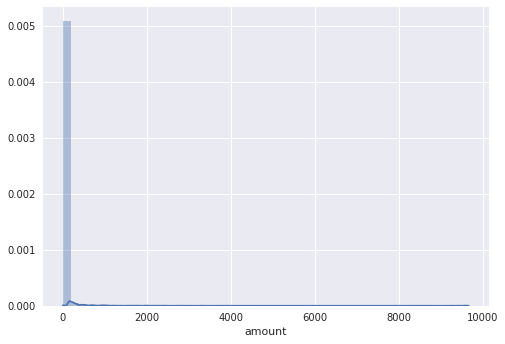

In [48]:
sns.distplot(df_pandas2['amount'])

In [49]:
df_pandas2.describe()

amount
count  38145.000000
mean      24.693223
std      190.879433
min        1.000000
25%        1.000000
50%        3.000000
75%       11.000000
max     9656.000000

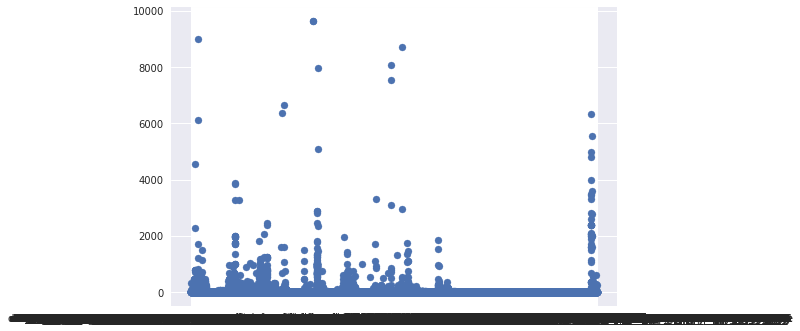

In [50]:
plt.scatter(df_pandas2['dataset'], df_pandas2['amount']);

Make dates categorical and apply one-hot-encoding. 

In [51]:
df_pandas2.dtypes

dataset    object
dt         object
amount      int64
dtype: object

In [52]:

df_pandas2.dt = pd.Categorical(df_pandas2.dt)
df_pandas2['code'] = df_pandas2.dt.cat.codes

df_pandas2

dataset          dt  amount  \
0      user.aleopold.hgtd_tt_mu200_newRPT_leadingEvt....  2018-03-30    9656   
1      user.aleopold.hgtd_tt_mu200_newRPT.2018_03_27_...  2018-03-28    9644   
2      data15_13TeV.periodJ.physics_Main.PhysCont.DAO...  2018-03-29    9004   
3      user.malutz.data16_13TeV.00304008.physics_Main...  2018-03-30    8706   
4      user.ljiang.data.data16_13TeV.00299184.physics...  2018-03-29    8058   
5      user.bbrunt.ChargeFlavourAsymm.XAODCode.data_1...  2018-03-28    7973   
6      user.ljiang.data.data16_13TeV.00299584.physics...  2018-03-31    7530   
7      mc16_13TeV.364352.Sherpa_224_NNPDF30NNLO_Dipho...  2018-03-28    6653   
8      mc16_13TeV.361224.Epos_minbias_inelastic.simul...  2018-03-28    6373   
9      user.vdao.mc15_13TeV.345786.PhPy8EG_NNPDF3_AZN...  2018-03-30    6351   
10     data15_13TeV.periodJ.physics_Main.PhysCont.DAO...  2018-03-28    6115   
11     user.vdao.mc15_13TeV.345823.PhPy8EG_NNPDF3_AZN...  2018-03-30    5537   
12     user.bbrunt.ChargeFlavourAsymm.XAODCode.data_1...  2018-03-28    5080   
13     user.vdao.mc15_13TeV.345792.PhPy8EG_NNPDF3_AZN...  2018-03-30    4972   
14     user.vdao.mc15_13TeV.345804.PhPy8EG_NNPDF3_AZN...  2018-03-30    4800   
15     data15_13TeV.00267385.physics_MinBias.recon.AO...  2018-03-29    4557   
16     user.vdao.mc15_13TeV.345798.PhPy8EG_NNPDF3_AZN...  2018-03-30    4000   
17     group.phys-higgs.mc15_13TeV.362449.Sherpa_Wenu...  2018-03-28    3886   
18     group.phys-higgs.mc15_13TeV.362449.Sherpa_Wenu...  2018-03-28    3861   
19     user.vdao.mc15_13TeV.345829.PhPy8EG_NNPDF3_AZN...  2018-03-30    3600   
20     user.vdao.mc15_13TeV.345817.PhPy8EG_NNPDF3_AZN...  2018-03-30    3488   
21     user.vdao.mc15_13TeV.345571.PowhegHerwig7EvtGe...  2018-03-30    3456   
22                     user.iconnell.Top.PRW.MC16c.FS.v1  2018-03-31    3309   
23     user.vdao.mc15_13TeV.345799.PhPy8EG_NNPDF3_AZN...  2018-03-30    3303   
24     group.phys-higgs.mc16_13TeV.361026.CAOD_HIGG5D...  2018-03-29    3294   
25     group.phys-higgs.mc15_13TeV.362449.Sherpa_Wenu...  2018-03-28    3264   
26     user.ljiang.data.data16_13TeV.00299184.physics...  2018-03-28    3085   
27     user.malutz.mc15_13TeV.361506.MadGraphPythia8E...  2018-03-30    2957   
28     user.artprod.atlas.21.3.Athena.x86_64-slc6-gcc...  2018-03-28    2885   
29     user.artprod.atlas.master.Athena.x86_64-slc6-g...  2018-03-29    2873   
...                                                  ...         ...     ...   
38115  group.phys-hi.mc15_5TeV.420022.PowhegPythia8Ev...  2018-03-29       1   
38116  user.lveloce.group.phys-higgs.mc16_13TeV.34423...  2018-03-28       1   
38117  user.ivivarel.406169.MadGraphPythia8EvtGen_A14...  2018-03-31       1   
38118                         user.vbegy.stagein8698.log  2018-03-28       1   
38119  user.sutt.atlas.21.0.Athena.x86_64-slc6-gcc62-...  2018-03-31       1   
38120  user.sutt.atlas.21.1.AthenaP1.x86_64-slc6-gcc6...  2018-03-31       1   
38121                         user.vbegy.stagein1645.log  2018-03-28       1   
38122  group.perf-jets.D17.00331239.Mar27.Zee.EM.p337...  2018-03-29       1   
38123                         user.vbegy.stagein6237.log  2018-03-29       1   
38124  user.fcirotto.bkg.mc16a.22Mar.mc16_13TeV.30809...  2018-03-28       1   
38125  user.thompson.data15_13TeV.00284427.CAOD_HIGG2...  2018-03-28       1   
38126  user.mazhang.410470.PhPy8EG_A14_ttbar_hdamp258...  2018-03-30       1   
38127                          user.vbegy.stagein334.log  2018-03-28       1   
38128  user.sdysch.v3.0.data15_13TeV.00270806.physics...  2018-03-31       1   
38129  user.sutt.atlas.21.0.Athena.x86_64-slc6-gcc62-...  2018-03-31       1   
38130  mc16_13TeV.431012.ParticleGun_pid22_E65536_dis...  2018-03-29       1   
38131  mc16_13TeV.431057.ParticleGun_pid22_E65536_dis...  2018-03-29       1   
38132  group.phys-higgs.mc16_13TeV.364173.CAOD_HIGG2D...  2018-03-29       1   
38133  group.phys-higgs.mc16_13TeV.364155.She221_

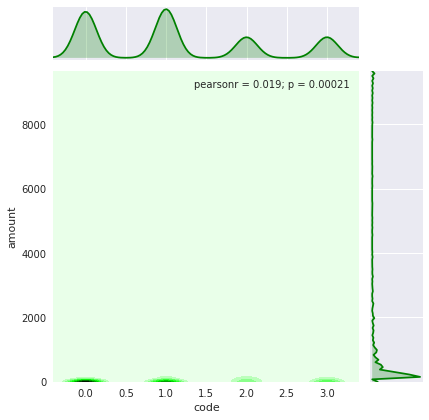

In [53]:
sns.jointplot('code', 'amount',
              data=df_pandas2, kind="kde", color="g");

In [54]:
df_pandas2.dtypes

dataset      object
dt         category
amount        int64
code           int8
dtype: object

In [55]:
df_pandas2['new_date'] = pd.to_datetime(df_pandas2['dt'])


In [56]:
df_pandas2.dtypes

dataset             object
dt                category
amount               int64
code                  int8
new_date    datetime64[ns]
dtype: object

In [57]:
df_pandas2.head()

dataset          dt  amount  \
0  user.aleopold.hgtd_tt_mu200_newRPT_leadingEvt....  2018-03-30    9656   
1  user.aleopold.hgtd_tt_mu200_newRPT.2018_03_27_...  2018-03-28    9644   
2  data15_13TeV.periodJ.physics_Main.PhysCont.DAO...  2018-03-29    9004   
3  user.malutz.data16_13TeV.00304008.physics_Main...  2018-03-30    8706   
4  user.ljiang.data.data16_13TeV.00299184.physics...  2018-03-29    8058   

   code   new_date  
0     2 2018-03-30  
1     0 2018-03-28  
2     1 2018-03-29  
3     2 2018-03-30  
4     1 2018-03-29

In [58]:
import datetime

df_pandas2['cache'] = np.where(((df_pandas2['new_date'] > datetime.datetime.now() - pd.to_timedelta("30day"))&(df_pandas2['amount'] > 100)), 'yes', 'no') 



In [59]:
df_pandas2.head()

dataset          dt  amount  \
0  user.aleopold.hgtd_tt_mu200_newRPT_leadingEvt....  2018-03-30    9656   
1  user.aleopold.hgtd_tt_mu200_newRPT.2018_03_27_...  2018-03-28    9644   
2  data15_13TeV.periodJ.physics_Main.PhysCont.DAO...  2018-03-29    9004   
3  user.malutz.data16_13TeV.00304008.physics_Main...  2018-03-30    8706   
4  user.ljiang.data.data16_13TeV.00299184.physics...  2018-03-29    8058   

   code   new_date cache  
0     2 2018-03-30   yes  
1     0 2018-03-28    no  
2     1 2018-03-29   yes  
3     2 2018-03-30   yes  
4     1 2018-03-29   yes

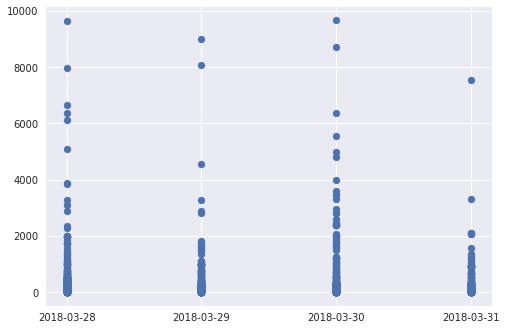

In [60]:
plt.scatter(df_pandas2['dt'], df_pandas2['amount']);